# Análisis Avanzado de Maduración en Salmón del Atlántico (*Salmo salar*)

## Contexto Biológico

La maduración sexual temprana en salmónidos de cultivo representa uno de los principales desafíos productivos en la salmonicultura moderna. Este fenómeno, particularmente crítico en *Salmo salar*, impacta significativamente:

- **Calidad del producto final**: Deterioro de la calidad de la carne
- **Rendimiento económico**: Reducción de la tasa de crecimiento somático
- **Eficiencia alimenticia**: Disminución en la conversión alimenticia
- **Bienestar animal**: Cambios fisiológicos y metabólicos

## Objetivos del Análisis

1. Identificar factores predictores de maduración sexual
2. Cuantificar el efecto del genotipo (Early vs Late) en la probabilidad de maduración
3. Evaluar la masa corporal y desarrollo gonadal como indicadores
4. Desarrollar modelos predictivos con aplicabilidad práctica en cultivo

---

**Autor:** Análisis Senior en Acuicultura  
**Fecha:** Enero 2026  
**Especie:** *Salmo salar* (Salmón del Atlántico)

## 1. Configuración del Entorno y Carga de Librerías

In [1]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelado estadístico
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score, accuracy_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler

# Estadística
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("✓ Librerías cargadas exitosamente")

✓ Librerías cargadas exitosamente


## 2. Generación de Datos Ampliados

Creamos un dataset sintético pero realista con 320 observaciones basado en parámetros biológicos de maduración en salmón del Atlántico.

In [2]:
# Configurar semilla para reproducibilidad
np.random.seed(42)

# Número de observaciones (ampliado)
n = 320

# Generar genotipos (E = Early, L = Late)
genotypes = np.random.choice(['E', 'L'], size=n, p=[0.5, 0.5])

# Generar masa corporal (g) - distribución realista para salmón en agua de mar
mass = np.random.normal(3500, 800, n)
mass[mass < 1500] = np.random.uniform(1500, 2000, sum(mass < 1500))

# Generar peso de gónada (g) - dependiente de genotipo y masa
gonad_base = np.where(
    genotypes == 'E',
    np.random.gamma(2, 15, n),  # Genotipo E: mayor desarrollo gonadal
    np.random.gamma(1.5, 12, n)  # Genotipo L: menor desarrollo gonadal
)
gonad = gonad_base + 0.008 * mass + np.random.normal(0, 5, n)
gonad[gonad < 10] = np.random.uniform(10, 20, sum(gonad < 10))

# Generar maduración (0 = No madura, 1 = Madura)
# Modelo logístico: P(Maduración) = f(masa, gónada, genotipo)
maturation_prob = 1 / (1 + np.exp(-(
    -8 + 0.0018 * mass + 0.05 * gonad + 1.2 * (genotypes == 'E')
)))

maturation = (np.random.random(n) < maturation_prob).astype(int)

# Crear DataFrame
maduracion = pd.DataFrame({
    'Fish': range(1, n + 1),
    'Genotype': genotypes,
    'Gonad': gonad.round(2),
    'Mass': mass.round(2),
    'Maturation': maturation
})

print(f"✓ Dataset generado con {n} observaciones\n")
print("Distribución de variables:")
print(f"  • Genotipos E: {sum(genotypes == 'E')} ({sum(genotypes == 'E')/n*100:.1f}%)")
print(f"  • Genotipos L: {sum(genotypes == 'L')} ({sum(genotypes == 'L')/n*100:.1f}%)")
print(f"  • Maduros: {sum(maturation)} ({sum(maturation)/n*100:.1f}%)")
print(f"  • No maduros: {sum(1-maturation)} ({sum(1-maturation)/n*100:.1f}%)")

# Guardar datos
maduracion.to_excel('Maturation_Extended.xlsx', index=False)
print("\n✓ Datos guardados en 'Maturation_Extended.xlsx'")

✓ Dataset generado con 320 observaciones

Distribución de variables:
  • Genotipos E: 154 (48.1%)
  • Genotipos L: 166 (51.9%)
  • Maduros: 216 (67.5%)
  • No maduros: 104 (32.5%)

✓ Datos guardados en 'Maturation_Extended.xlsx'


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Estructura y Resumen de Datos

In [3]:
# Información general
print("="*60)
print("INFORMACIÓN DEL DATASET")
print("="*60)
print(maduracion.info())
print("\n" + "="*60)
print("PRIMERAS 10 OBSERVACIONES")
print("="*60)
display(maduracion.head(10))

print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
display(maduracion.describe().round(2))

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fish        320 non-null    int64  
 1   Genotype    320 non-null    object 
 2   Gonad       320 non-null    float64
 3   Mass        320 non-null    float64
 4   Maturation  320 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 12.6+ KB
None

PRIMERAS 10 OBSERVACIONES


,Fish,Genotype,Gonad,Mass,Maturation
0,1,E,94.36,4912.36,1
1,2,L,41.09,3823.99,1
2,3,L,62.68,2491.29,1
3,4,L,32.71,4234.29,1
4,5,E,49.39,5197.72,1
5,6,E,65.77,4325.97,1
6,7,E,31.61,2284.50,0
7,8,L,50.44,3112.61,0
8,9,L,49.13,4513.53,1
9,10,L,49.14,2933.86,1



ESTADÍSTICAS DESCRIPTIVAS


,Fish,Gonad,Mass,Maturation
count,320.00,320.00,320.00,320.00
mean,160.50,51.40,3488.21,0.68
std,92.52,20.85,780.43,0.47
min,1.00,13.98,1522.68,0.00
25%,80.75,37.58,2931.70,0.00
50%,160.50,47.75,3484.99,1.00
75%,240.25,60.07,4002.94,1.00
max,320.00,166.10,5963.10,1.00


### 3.2 Análisis por Genotipo

In [4]:
# Estadísticas por genotipo
print("="*60)
print("COMPARACIÓN POR GENOTIPO")
print("="*60)

for genotype in ['E', 'L']:
    subset = maduracion[maduracion['Genotype'] == genotype]
    mat_rate = subset['Maturation'].mean() * 100
    gen_name = "Early (Maduración Temprana)" if genotype == 'E' else "Late (Maduración Tardía)"
    
    print(f"\n{gen_name}:")
    print(f"  • N = {len(subset)}")
    print(f"  • Tasa de maduración: {mat_rate:.1f}%")
    print(f"  • Masa corporal: {subset['Mass'].mean():.1f} ± {subset['Mass'].std():.1f} g")
    print(f"  • Peso gónada: {subset['Gonad'].mean():.1f} ± {subset['Gonad'].std():.1f} g")

# Tabla de contingencia
print("\n" + "="*60)
print("TABLA DE CONTINGENCIA: Genotipo vs Maduración")
print("="*60)
contingency = pd.crosstab(maduracion['Genotype'], maduracion['Maturation'], 
                          rownames=['Genotipo'], colnames=['Maduración'])
contingency.columns = ['No Maduro (0)', 'Maduro (1)']
display(contingency)

# Test Chi-cuadrado
chi2, p_val, dof, expected = chi2_contingency(contingency)
print(f"\nChi-cuadrado: χ² = {chi2:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("→ Existe asociación significativa entre genotipo y maduración")
else:
    print("→ No hay asociación significativa entre genotipo y maduración")

COMPARACIÓN POR GENOTIPO

Early (Maduración Temprana):
  • N = 154
  • Tasa de maduración: 76.0%
  • Masa corporal: 3394.9 ± 815.1 g
  • Peso gónada: 57.3 ± 24.5 g

Late (Maduración Tardía):
  • N = 166
  • Tasa de maduración: 59.6%
  • Masa corporal: 3574.7 ± 738.8 g
  • Peso gónada: 46.0 ± 14.9 g

TABLA DE CONTINGENCIA: Genotipo vs Maduración


,No Maduro (0),Maduro (1)
Genotipo,,
E,37,117
L,67,99



Chi-cuadrado: χ² = 8.9871, p-value = 0.0027
→ Existe asociación significativa entre genotipo y maduración


### 3.3 Visualización Exploratoria

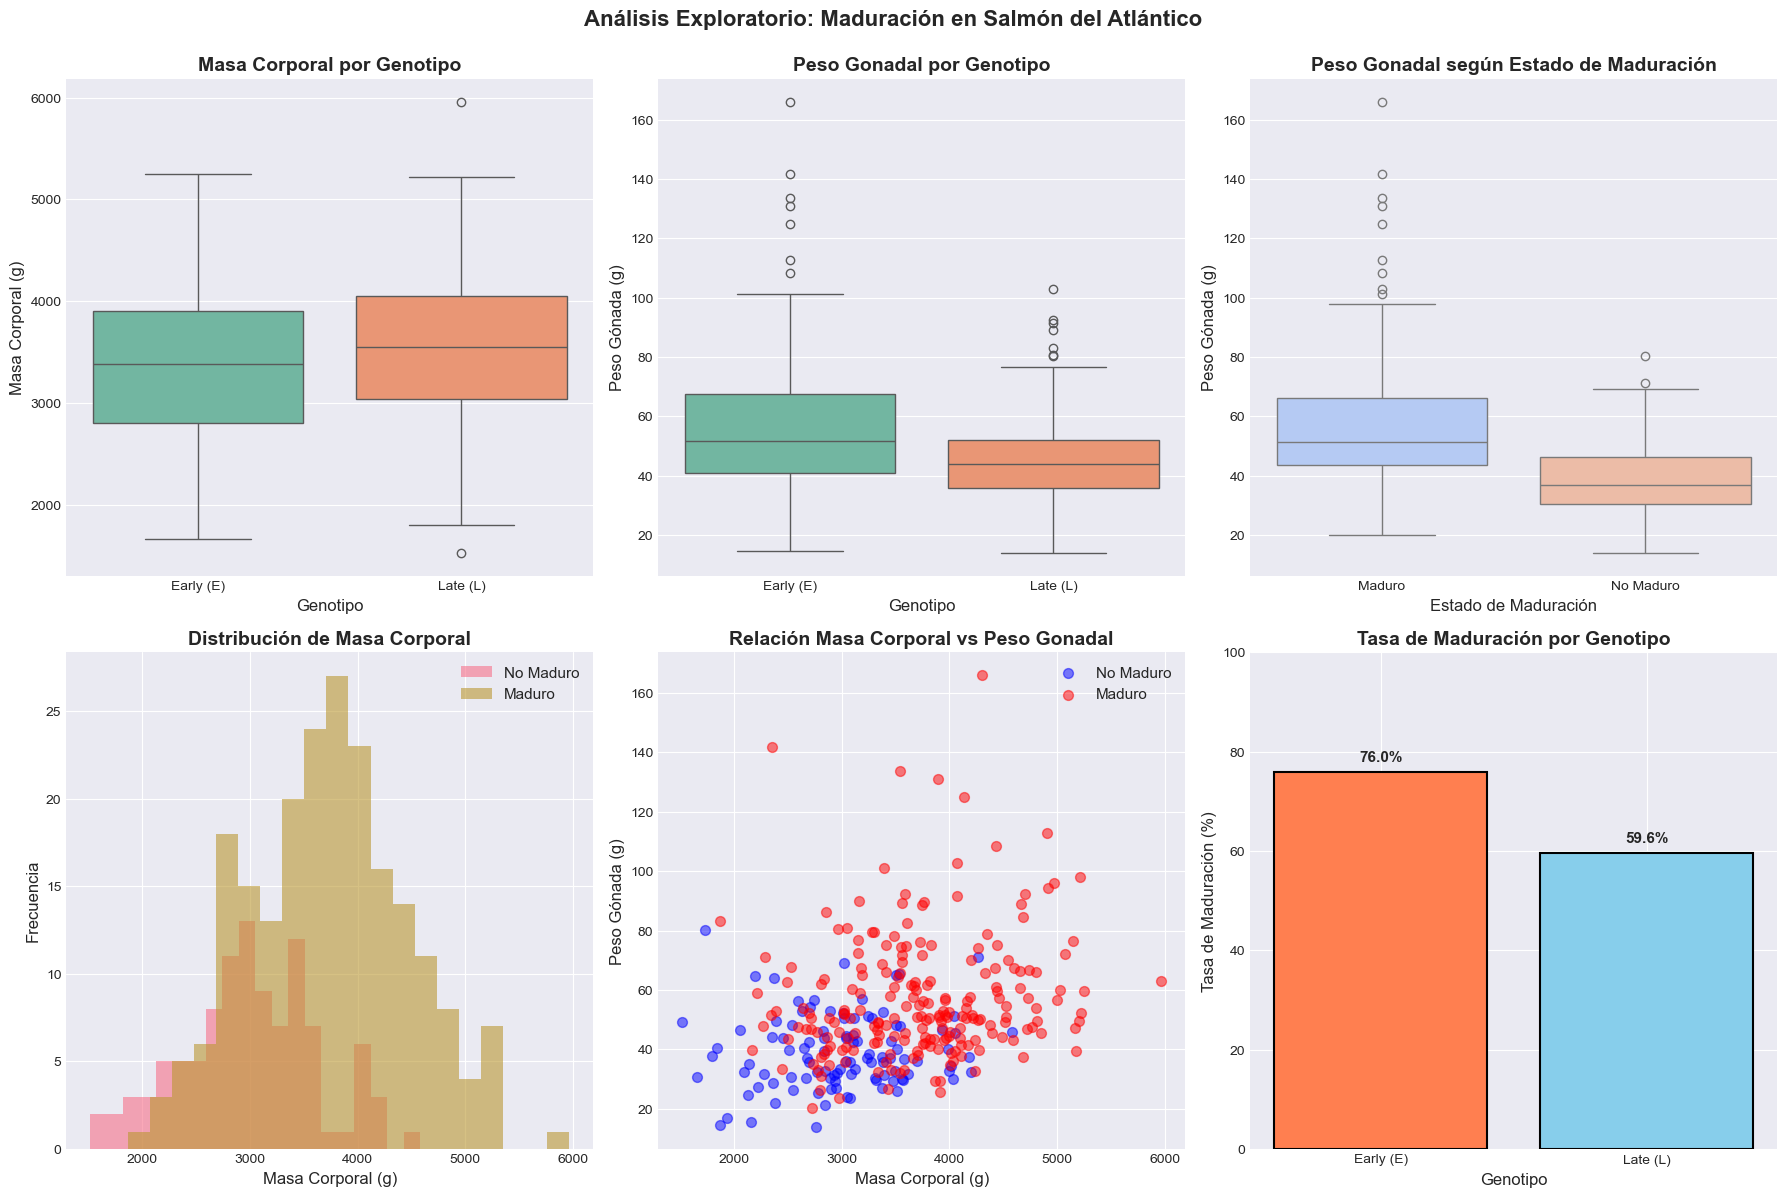

✓ Gráficos exploratorios generados


In [5]:
# Configuración de figura con múltiples subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio: Maduración en Salmón del Atlántico', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Distribución de masa corporal por genotipo
sns.boxplot(data=maduracion, x='Genotype', y='Mass', hue='Genotype', 
            ax=axes[0,0], palette='Set2', legend=False)
axes[0,0].set_title('Masa Corporal por Genotipo', fontweight='bold')
axes[0,0].set_xlabel('Genotipo')
axes[0,0].set_ylabel('Masa Corporal (g)')
axes[0,0].set_xticklabels(['Early (E)', 'Late (L)'])

# 2. Distribución de peso gonadal por genotipo
sns.boxplot(data=maduracion, x='Genotype', y='Gonad', hue='Genotype', 
            ax=axes[0,1], palette='Set2', legend=False)
axes[0,1].set_title('Peso Gonadal por Genotipo', fontweight='bold')
axes[0,1].set_xlabel('Genotipo')
axes[0,1].set_ylabel('Peso Gónada (g)')
axes[0,1].set_xticklabels(['Early (E)', 'Late (L)'])

# 3. Peso gonadal por estado de maduración
maduracion['Mat_Label'] = maduracion['Maturation'].map({0: 'No Maduro', 1: 'Maduro'})
sns.boxplot(data=maduracion, x='Mat_Label', y='Gonad', hue='Mat_Label', 
            ax=axes[0,2], palette='coolwarm', legend=False)
axes[0,2].set_title('Peso Gonadal según Estado de Maduración', fontweight='bold')
axes[0,2].set_xlabel('Estado de Maduración')
axes[0,2].set_ylabel('Peso Gónada (g)')

# 4. Histograma de masa corporal por maduración
for mat_status in [0, 1]:
    subset = maduracion[maduracion['Maturation'] == mat_status]
    label = 'Maduro' if mat_status == 1 else 'No Maduro'
    axes[1,0].hist(subset['Mass'], bins=20, alpha=0.6, label=label)
axes[1,0].set_title('Distribución de Masa Corporal', fontweight='bold')
axes[1,0].set_xlabel('Masa Corporal (g)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend()

# 5. Scatter plot: Masa vs Peso Gonadal
colors = {0: 'blue', 1: 'red'}
for mat_status in [0, 1]:
    subset = maduracion[maduracion['Maturation'] == mat_status]
    label = 'Maduro' if mat_status == 1 else 'No Maduro'
    axes[1,1].scatter(subset['Mass'], subset['Gonad'], 
                     c=colors[mat_status], alpha=0.5, s=50, label=label)
axes[1,1].set_title('Relación Masa Corporal vs Peso Gonadal', fontweight='bold')
axes[1,1].set_xlabel('Masa Corporal (g)')
axes[1,1].set_ylabel('Peso Gónada (g)')
axes[1,1].legend()

# 6. Tasa de maduración por genotipo
mat_rates = maduracion.groupby('Genotype')['Maturation'].mean() * 100
axes[1,2].bar(['Early (E)', 'Late (L)'], mat_rates, color=['coral', 'skyblue'], 
              edgecolor='black', linewidth=1.5)
axes[1,2].set_title('Tasa de Maduración por Genotipo', fontweight='bold')
axes[1,2].set_xlabel('Genotipo')
axes[1,2].set_ylabel('Tasa de Maduración (%)')
axes[1,2].set_ylim(0, 100)
for i, (genotype, rate) in enumerate(mat_rates.items()):
    axes[1,2].text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('Exploratorio_Maduracion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficos exploratorios generados")

### 3.4 Pruebas de Normalidad y Homogeneidad de Varianzas

In [6]:
print("="*60)
print("PRUEBAS DE SUPUESTOS ESTADÍSTICOS")
print("="*60)

# Test de normalidad (Shapiro-Wilk)
print("\n1. Test de Normalidad (Shapiro-Wilk):")
for col in ['Mass', 'Gonad']:
    stat, p_val = shapiro(maduracion[col])
    print(f"   {col}: W = {stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(f"   → {col} NO sigue distribución normal")
    else:
        print(f"   → {col} sigue distribución normal")

# Test de homogeneidad de varianzas (Levene)
print("\n2. Test de Homogeneidad de Varianzas (Levene):")
for col in ['Mass', 'Gonad']:
    group_e = maduracion[maduracion['Genotype'] == 'E'][col]
    group_l = maduracion[maduracion['Genotype'] == 'L'][col]
    stat, p_val = levene(group_e, group_l)
    print(f"   {col}: W = {stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(f"   → Varianzas NO homogéneas entre genotipos")
    else:
        print(f"   → Varianzas homogéneas entre genotipos")

# Test U de Mann-Whitney (no paramétrico)
print("\n3. Test U de Mann-Whitney (Comparación entre Genotipos):")
for col in ['Mass', 'Gonad']:
    group_e = maduracion[maduracion['Genotype'] == 'E'][col]
    group_l = maduracion[maduracion['Genotype'] == 'L'][col]
    stat, p_val = mannwhitneyu(group_e, group_l)
    print(f"   {col}: U = {stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(f"   → Diferencia significativa entre genotipos")
    else:
        print(f"   → NO hay diferencia significativa entre genotipos")

PRUEBAS DE SUPUESTOS ESTADÍSTICOS

1. Test de Normalidad (Shapiro-Wilk):
   Mass: W = 0.9961, p-value = 0.6192
   → Mass sigue distribución normal
   Gonad: W = 0.8911, p-value = 0.0000
   → Gonad NO sigue distribución normal

2. Test de Homogeneidad de Varianzas (Levene):
   Mass: W = 2.1659, p-value = 0.1421
   → Varianzas homogéneas entre genotipos
   Gonad: W = 15.8380, p-value = 0.0001
   → Varianzas NO homogéneas entre genotipos

3. Test U de Mann-Whitney (Comparación entre Genotipos):
   Mass: U = 10998.0000, p-value = 0.0310
   → Diferencia significativa entre genotipos
   Gonad: U = 16633.0000, p-value = 0.0000
   → Diferencia significativa entre genotipos


## 4. Matriz de Correlación

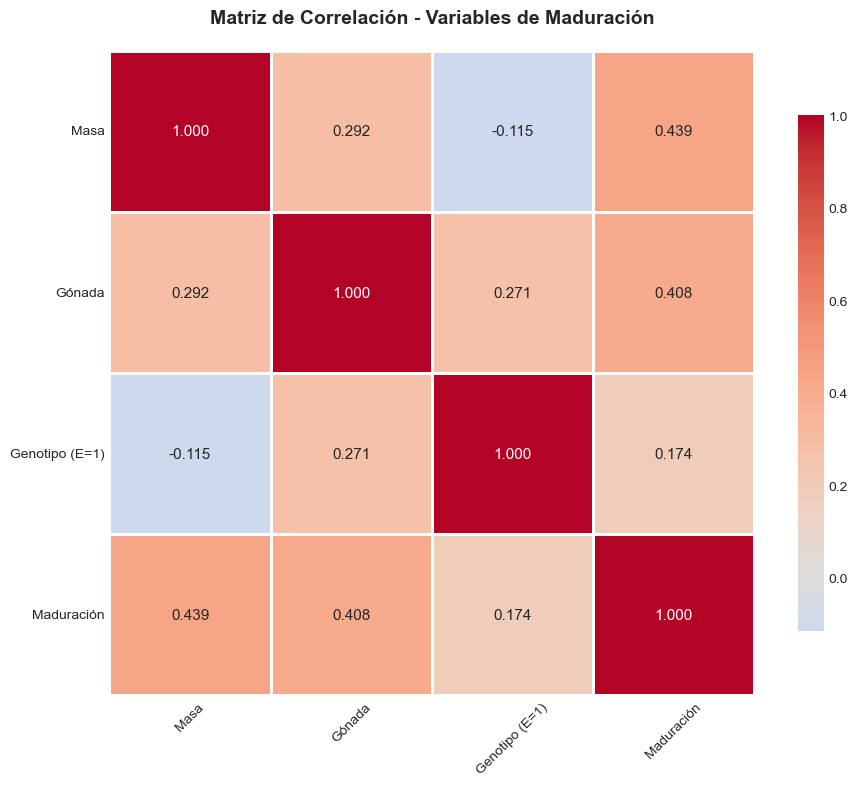


✓ Matriz de correlación generada

Correlaciones con Maduración:
Maturation      1.000000
Mass            0.438794
Gonad           0.408182
Genotype_Num    0.174262
Name: Maturation, dtype: float64


In [7]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
maduracion['Genotype_Num'] = (maduracion['Genotype'] == 'E').astype(int)
corr_data = maduracion[['Mass', 'Gonad', 'Genotype_Num', 'Maturation']]
corr_matrix = corr_data.corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables de Maduración', fontsize=14, fontweight='bold', pad=20)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], 
           labels=['Masa', 'Gónada', 'Genotipo (E=1)', 'Maduración'], rotation=45)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], 
           labels=['Masa', 'Gónada', 'Genotipo (E=1)', 'Maduración'], rotation=0)
plt.tight_layout()
plt.savefig('Matriz_Correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Matriz de correlación generada")
print("\nCorrelaciones con Maduración:")
print(corr_matrix['Maturation'].sort_values(ascending=False))

## 5. Regresión Logística

### 5.1 Modelo Nulo (Solo Intercepto)

In [8]:
# Modelo nulo usando statsmodels para obtener estadísticas detalladas
modelo_nulo = logit('Maturation ~ 1', data=maduracion).fit()

print("="*60)
print("MODELO NULO (SOLO INTERCEPTO)")
print("="*60)
print(modelo_nulo.summary())

print(f"\nAIC: {modelo_nulo.aic:.2f}")
print(f"BIC: {modelo_nulo.bic:.2f}")

Optimization terminated successfully.
         Current function value: 0.630581
         Iterations 4
MODELO NULO (SOLO INTERCEPTO)
                           Logit Regression Results                           
Dep. Variable:             Maturation   No. Observations:                  320
Model:                          Logit   Df Residuals:                      319
Method:                           MLE   Df Model:                            0
Date:                Wed, 21 Jan 2026   Pseudo R-squ.:               2.722e-11
Time:                        20:23:07   Log-Likelihood:                -201.79
converged:                       True   LL-Null:                       -201.79
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7309      0.119      6.124      0.000       0.497       0.965

### 5.2 Modelo Simple: Maduración ~ Masa Corporal

In [9]:
# Modelo logístico simple
modelo_simple = logit('Maturation ~ Mass', data=maduracion).fit()

print("="*60)
print("MODELO SIMPLE: Maduración ~ Masa Corporal")
print("="*60)
print(modelo_simple.summary())

print(f"\nAIC: {modelo_simple.aic:.2f}")
print(f"BIC: {modelo_simple.bic:.2f}")

# Odds Ratio
print("\n" + "="*60)
print("ODDS RATIO E INTERPRETACIÓN")
print("="*60)
odds_ratio_mass = np.exp(modelo_simple.params['Mass'])
print(f"\nOdds Ratio (Masa): {odds_ratio_mass:.6f}")
print(f"Interpretación: Por cada gramo adicional de masa corporal,")
print(f"las probabilidades de madurar aumentan en {(odds_ratio_mass - 1) * 100:.4f}%")

# Por cada 100g
or_100g = np.exp(modelo_simple.params['Mass'] * 100)
print(f"\nPor cada 100g adicionales, las probabilidades de madurar")
print(f"aumentan en {(or_100g - 1) * 100:.2f}%")

Optimization terminated successfully.
         Current function value: 0.522040
         Iterations 6
MODELO SIMPLE: Maduración ~ Masa Corporal
                           Logit Regression Results                           
Dep. Variable:             Maturation   No. Observations:                  320
Model:                          Logit   Df Residuals:                      318
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Jan 2026   Pseudo R-squ.:                  0.1721
Time:                        20:23:07   Log-Likelihood:                -167.05
converged:                       True   LL-Null:                       -201.79
Covariance Type:            nonrobust   LLR p-value:                 7.774e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3972      0.713     -6.165      0.000      -5.795

### 5.3 Visualización del Modelo Simple

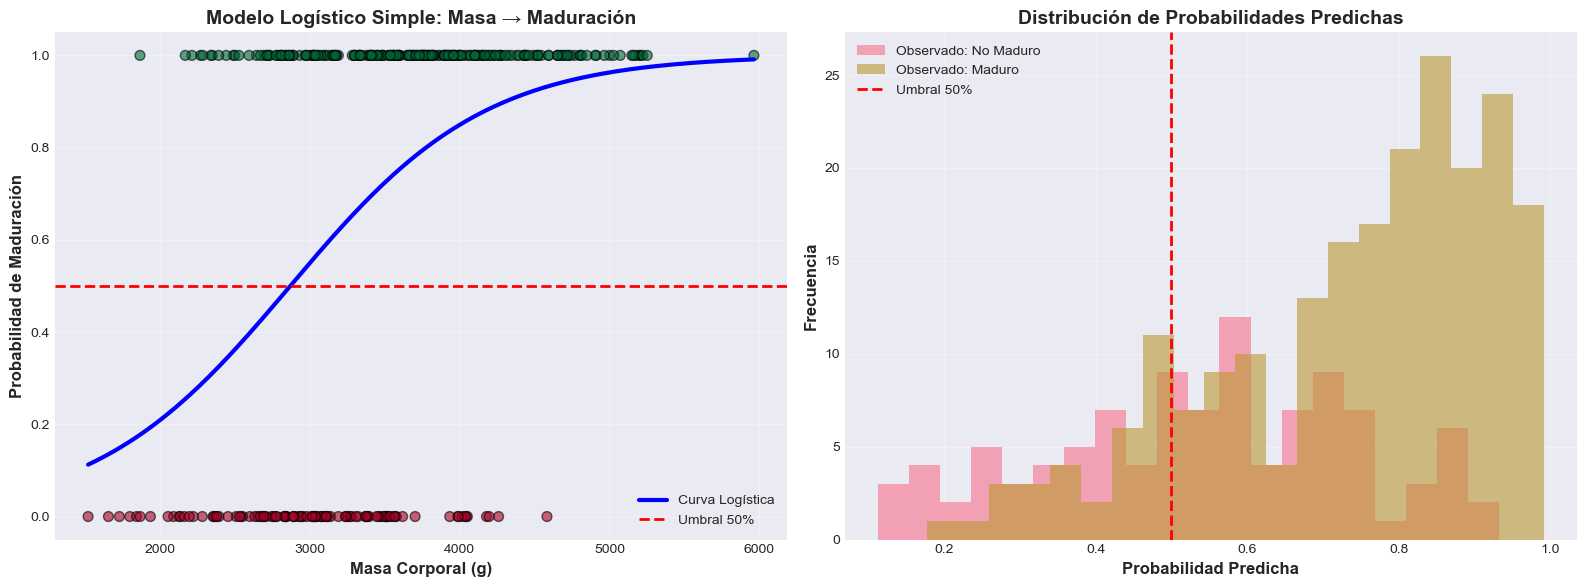

✓ Visualización del modelo simple generada


In [10]:
# Crear figura con predicciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Datos observados + curva logística
mass_range = np.linspace(maduracion['Mass'].min(), maduracion['Mass'].max(), 200)
pred_prob = modelo_simple.predict(sm.add_constant(pd.DataFrame({'Mass': mass_range})))

axes[0].scatter(maduracion['Mass'], maduracion['Maturation'], 
               c=maduracion['Maturation'], cmap='RdYlGn', alpha=0.6, s=50, edgecolors='black')
axes[0].plot(mass_range, pred_prob, 'b-', linewidth=3, label='Curva Logística')
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Umbral 50%')
axes[0].set_xlabel('Masa Corporal (g)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Probabilidad de Maduración', fontsize=12, fontweight='bold')
axes[0].set_title('Modelo Logístico Simple: Masa → Maduración', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Panel 2: Distribución de probabilidades predichas
pred_prob_all = modelo_simple.predict(sm.add_constant(maduracion[['Mass']]))
for mat_status in [0, 1]:
    subset_probs = pred_prob_all[maduracion['Maturation'] == mat_status]
    label = 'Observado: Maduro' if mat_status == 1 else 'Observado: No Maduro'
    axes[1].hist(subset_probs, bins=20, alpha=0.6, label=label)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Umbral 50%')
axes[1].set_xlabel('Probabilidad Predicha', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Modelo_Logistico_Simple.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización del modelo simple generada")

### 5.4 Modelo Múltiple: Maduración ~ Masa + Genotipo

In [11]:
# Modelo múltiple
modelo_multiple = logit('Maturation ~ Mass + C(Genotype)', data=maduracion).fit()

print("="*60)
print("MODELO MÚLTIPLE: Maduración ~ Masa + Genotipo")
print("="*60)
print(modelo_multiple.summary())

print(f"\nAIC: {modelo_multiple.aic:.2f}")
print(f"BIC: {modelo_multiple.bic:.2f}")

# Odds Ratios
print("\n" + "="*60)
print("ODDS RATIOS E INTERPRETACIÓN BIOLÓGICA")
print("="*60)

or_mass_mult = np.exp(modelo_multiple.params['Mass'])
print(f"\n1. Masa Corporal:")
print(f"   OR = {or_mass_mult:.6f}")
print(f"   Por cada gramo adicional: +{(or_mass_mult - 1) * 100:.4f}% en odds de madurar")
print(f"   Por cada 100g: +{(np.exp(modelo_multiple.params['Mass'] * 100) - 1) * 100:.2f}% en odds")

if 'C(Genotype)[T.L]' in modelo_multiple.params:
    or_genotype = np.exp(modelo_multiple.params['C(Genotype)[T.L]'])
    print(f"\n2. Genotipo Late vs Early:")
    print(f"   OR = {or_genotype:.4f}")
    if or_genotype < 1:
        print(f"   El genotipo Late tiene {(1 - or_genotype) * 100:.2f}% menos odds de madurar")
        print(f"   que el genotipo Early (controlando por masa corporal)")
    else:
        print(f"   El genotipo Late tiene {(or_genotype - 1) * 100:.2f}% más odds de madurar")
        print(f"   que el genotipo Early (controlando por masa corporal)")

print("\n" + "="*60)
print("IMPLICACIONES PARA EL CULTIVO")
print("="*60)
print("• La masa corporal es un predictor significativo de maduración")
print("• El genotipo influye independientemente en la probabilidad de maduración")
print("• Estrategia recomendada: Selección genética + control de peso")

Optimization terminated successfully.
         Current function value: 0.484543
         Iterations 6
MODELO MÚLTIPLE: Maduración ~ Masa + Genotipo
                           Logit Regression Results                           
Dep. Variable:             Maturation   No. Observations:                  320
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            2
Date:                Wed, 21 Jan 2026   Pseudo R-squ.:                  0.2316
Time:                        20:23:09   Log-Likelihood:                -155.05
converged:                       True   LL-Null:                       -201.79
Covariance Type:            nonrobust   LLR p-value:                 5.064e-21
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.5977      0.756     -6.078 

### 5.5 Modelo Completo: Maduración ~ Masa + Gónada + Genotipo

In [12]:
# Modelo completo
modelo_completo = logit('Maturation ~ Mass + Gonad + C(Genotype)', data=maduracion).fit()

print("="*60)
print("MODELO COMPLETO: Maduración ~ Masa + Gónada + Genotipo")
print("="*60)
print(modelo_completo.summary())

print(f"\nAIC: {modelo_completo.aic:.2f}")
print(f"BIC: {modelo_completo.bic:.2f}")

Optimization terminated successfully.
         Current function value: 0.425899
         Iterations 7
MODELO COMPLETO: Maduración ~ Masa + Gónada + Genotipo
                           Logit Regression Results                           
Dep. Variable:             Maturation   No. Observations:                  320
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Jan 2026   Pseudo R-squ.:                  0.3246
Time:                        20:23:09   Log-Likelihood:                -136.29
converged:                       True   LL-Null:                       -201.79
Covariance Type:            nonrobust   LLR p-value:                 3.298e-28
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.1277      1.001   

### 5.6 Comparación de Modelos

In [13]:
# Tabla comparativa
comparacion = pd.DataFrame({
    'Modelo': ['Nulo', 'Simple (Masa)', 'Múltiple (Masa + Genotipo)', 'Completo (Masa + Gónada + Genotipo)'],
    'AIC': [modelo_nulo.aic, modelo_simple.aic, modelo_multiple.aic, modelo_completo.aic],
    'BIC': [modelo_nulo.bic, modelo_simple.bic, modelo_multiple.bic, modelo_completo.bic],
    'Log-Likelihood': [modelo_nulo.llf, modelo_simple.llf, modelo_multiple.llf, modelo_completo.llf],
    'N_Params': [len(modelo_nulo.params), len(modelo_simple.params), 
                 len(modelo_multiple.params), len(modelo_completo.params)]
})

print("="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
display(comparacion.round(2))

# Mejor modelo por AIC
best_aic_idx = comparacion['AIC'].idxmin()
best_model_aic = comparacion.loc[best_aic_idx, 'Modelo']
print(f"\n✓ Mejor modelo según AIC (menor es mejor): {best_model_aic}")

# Test de razón de verosimilitud
print("\n" + "="*80)
print("TEST DE RAZÓN DE VEROSIMILITUD (LRT)")
print("="*80)

# Comparar modelos anidados
from scipy.stats import chi2 as chi2_dist

# Nulo vs Simple
lr_stat = 2 * (modelo_simple.llf - modelo_nulo.llf)
df = len(modelo_simple.params) - len(modelo_nulo.params)
p_val = 1 - chi2_dist.cdf(lr_stat, df)
print(f"\nNulo vs Simple:")
print(f"  LR χ² = {lr_stat:.4f}, df = {df}, p-value = {p_val:.4e}")
if p_val < 0.05:
    print("  → Modelo Simple es significativamente mejor")

# Simple vs Múltiple
lr_stat = 2 * (modelo_multiple.llf - modelo_simple.llf)
df = len(modelo_multiple.params) - len(modelo_simple.params)
p_val = 1 - chi2_dist.cdf(lr_stat, df)
print(f"\nSimple vs Múltiple:")
print(f"  LR χ² = {lr_stat:.4f}, df = {df}, p-value = {p_val:.4e}")
if p_val < 0.05:
    print("  → Modelo Múltiple es significativamente mejor")

# Múltiple vs Completo
lr_stat = 2 * (modelo_completo.llf - modelo_multiple.llf)
df = len(modelo_completo.params) - len(modelo_multiple.params)
p_val = 1 - chi2_dist.cdf(lr_stat, df)
print(f"\nMúltiple vs Completo:")
print(f"  LR χ² = {lr_stat:.4f}, df = {df}, p-value = {p_val:.4e}")
if p_val < 0.05:
    print("  → Modelo Completo es significativamente mejor")
else:
    print("  → NO hay mejora significativa con el Modelo Completo")

COMPARACIÓN DE MODELOS


,Modelo,AIC,BIC,Log-Likelihood,N_Params
0,Nulo,405.57,409.34,-201.79,1
1,Simple (Masa),338.11,345.64,-167.05,2
2,Múltiple (Masa + Genotipo),316.11,327.41,-155.05,3
3,Completo (Masa + Gónada + Genotipo),280.58,295.65,-136.29,4



✓ Mejor modelo según AIC (menor es mejor): Completo (Masa + Gónada + Genotipo)

TEST DE RAZÓN DE VEROSIMILITUD (LRT)

Nulo vs Simple:
  LR χ² = 69.4661, df = 1, p-value = 1.1102e-16
  → Modelo Simple es significativamente mejor

Simple vs Múltiple:
  LR χ² = 23.9981, df = 1, p-value = 9.6431e-07
  → Modelo Múltiple es significativamente mejor

Múltiple vs Completo:
  LR χ² = 37.5325, df = 1, p-value = 8.9904e-10
  → Modelo Completo es significativamente mejor


## 6. Evaluación del Modelo y Métricas de Rendimiento

### 6.1 Predicciones y Matriz de Confusión

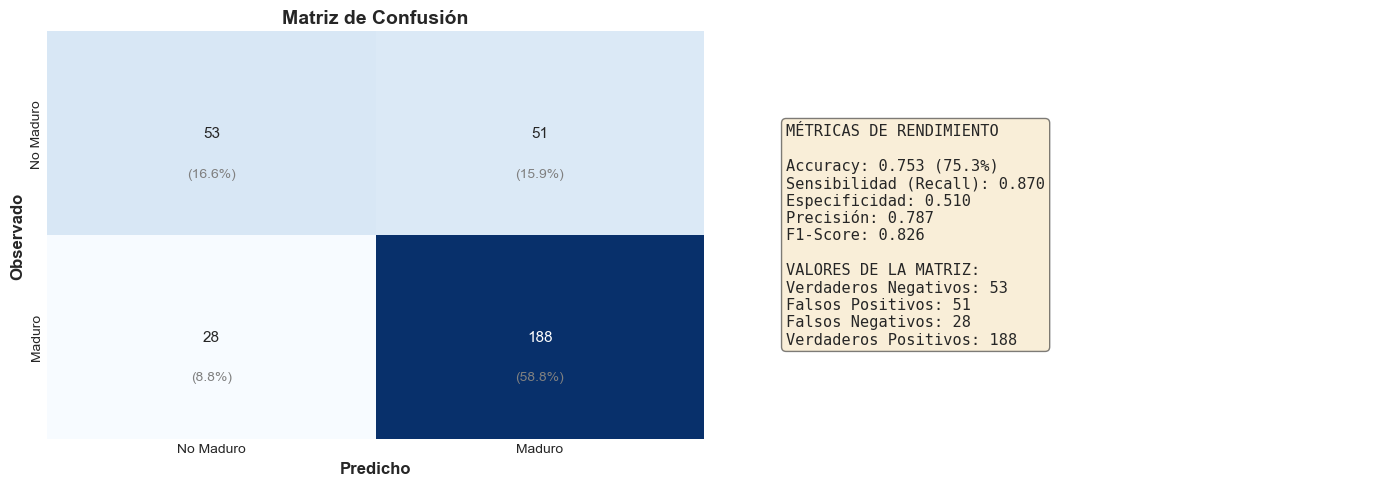

✓ Matriz de confusión y métricas generadas


In [14]:
# Usar el mejor modelo (múltiple) para evaluación
modelo_final = modelo_multiple

# Predicciones
maduracion['Pred_Prob'] = modelo_final.predict()
maduracion['Pred_Class'] = (maduracion['Pred_Prob'] >= 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(maduracion['Maturation'], maduracion['Pred_Class'])

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Maduro', 'Maduro'], 
            yticklabels=['No Maduro', 'Maduro'], cbar=False)
axes[0].set_xlabel('Predicho', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Observado', fontsize=12, fontweight='bold')
axes[0].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')

# Agregar porcentajes
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / cm.sum() * 100
        axes[0].text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

# Métricas de clasificación
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

metrics_text = f"""MÉTRICAS DE RENDIMIENTO

Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)
Sensibilidad (Recall): {sensitivity:.3f}
Especificidad: {specificity:.3f}
Precisión: {precision:.3f}
F1-Score: {f1:.3f}

VALORES DE LA MATRIZ:
Verdaderos Negativos: {tn}
Falsos Positivos: {fp}
Falsos Negativos: {fn}
Verdaderos Positivos: {tp}"""

axes[1].text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
            family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].axis('off')

plt.tight_layout()
plt.savefig('Matriz_Confusion_Metricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusión y métricas generadas")

### 6.2 Curva ROC y AUC

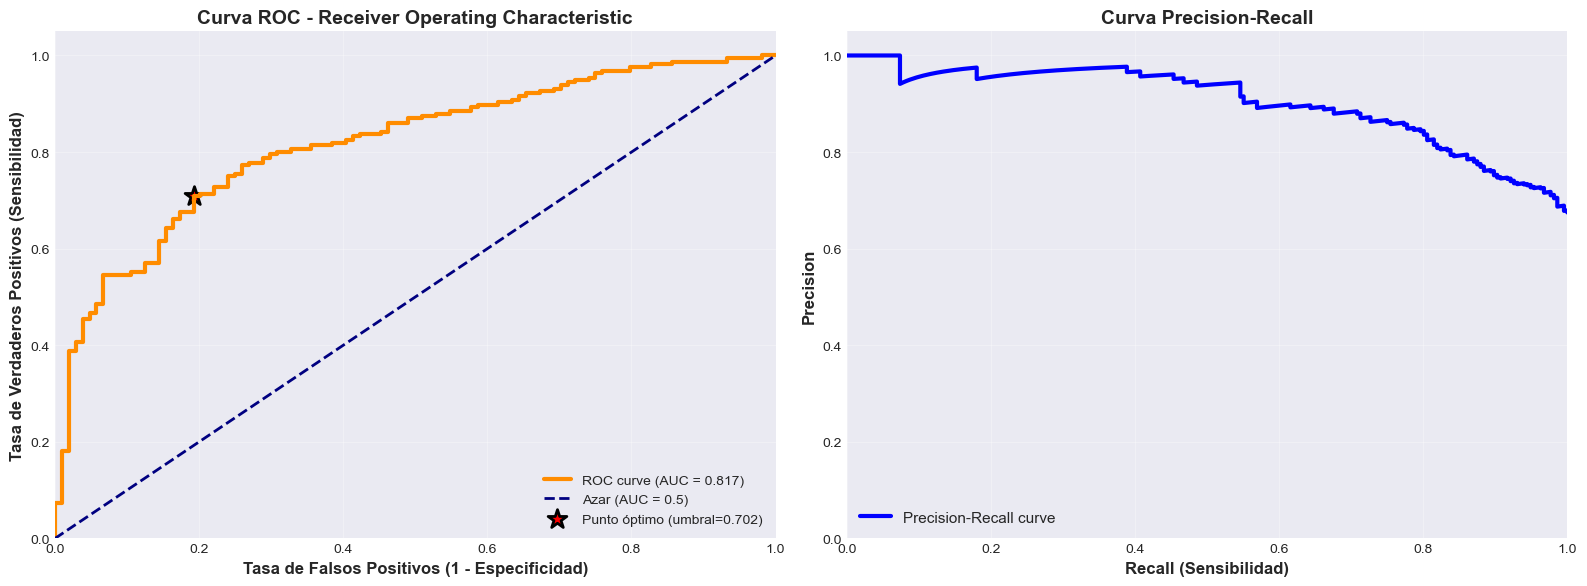


INTERPRETACIÓN DEL AUC

AUC = 0.817
→ Buena capacidad predictiva

Umbral óptimo: 0.702
En el punto óptimo:
  • Sensibilidad = 0.708
  • Especificidad = 0.808


In [15]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(maduracion['Maturation'], maduracion['Pred_Prob'])
roc_auc = auc(fpr, tpr)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Curva ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=3, 
            label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12, fontweight='bold')
axes[0].set_title('Curva ROC - Receiver Operating Characteristic', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, alpha=0.3)

# Agregar punto óptimo
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], s=200, c='red', 
               marker='*', edgecolors='black', linewidths=2, 
               label=f'Punto óptimo (umbral={optimal_threshold:.3f})')
axes[0].legend(loc="lower right", fontsize=10)

# Panel 2: Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    maduracion['Maturation'], maduracion['Pred_Prob']
)
axes[1].plot(recall_vals, precision_vals, color='blue', lw=3, label='Precision-Recall curve')
axes[1].set_xlabel('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Curva Precision-Recall', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('ROC_PrecisionRecall.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("INTERPRETACIÓN DEL AUC")
print(f"{'='*60}")
print(f"\nAUC = {roc_auc:.3f}")
if roc_auc >= 0.9:
    print("→ Excelente capacidad predictiva")
elif roc_auc >= 0.8:
    print("→ Buena capacidad predictiva")
elif roc_auc >= 0.7:
    print("→ Capacidad predictiva aceptable")
else:
    print("→ Capacidad predictiva pobre")

print(f"\nUmbral óptimo: {optimal_threshold:.3f}")
print(f"En el punto óptimo:")
print(f"  • Sensibilidad = {tpr[optimal_idx]:.3f}")
print(f"  • Especificidad = {1 - fpr[optimal_idx]:.3f}")

### 6.3 Validación Cruzada

VALIDACIÓN CRUZADA (10-FOLD)

Accuracy por fold:
  Fold  1: 0.7500
  Fold  2: 0.6875
  Fold  3: 0.6250
  Fold  4: 0.7500
  Fold  5: 0.8125
  Fold  6: 0.8438
  Fold  7: 0.8125
  Fold  8: 0.7188
  Fold  9: 0.6250
  Fold 10: 0.8125

Accuracy media: 0.7438 ± 0.0750
AUC media: 0.8023 ± 0.0507


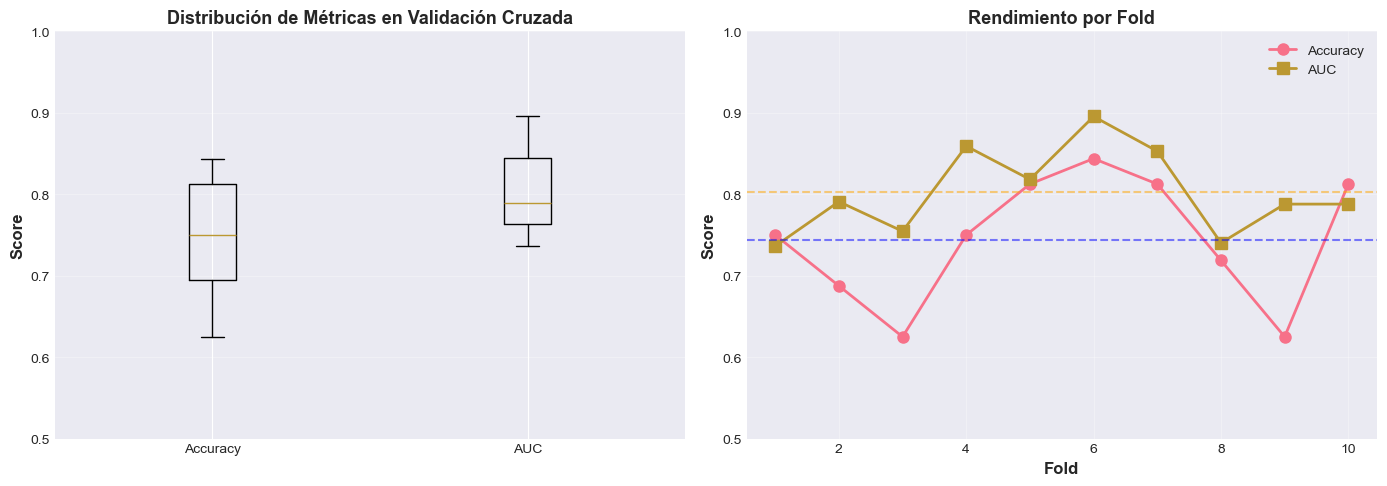


✓ Validación cruzada completada


In [16]:
# Preparar datos para sklearn
X = maduracion[['Mass']].values
X_genotype = pd.get_dummies(maduracion['Genotype'], drop_first=True).values
X_multiple = np.column_stack([X, X_genotype])
y = maduracion['Maturation'].values

# Modelo de regresión logística con sklearn
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Validación cruzada estratificada (10-fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_multiple, y, cv=cv, scoring='accuracy')
cv_scores_auc = cross_val_score(log_reg, X_multiple, y, cv=cv, scoring='roc_auc')

print("="*60)
print("VALIDACIÓN CRUZADA (10-FOLD)")
print("="*60)
print(f"\nAccuracy por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i:2d}: {score:.4f}")

print(f"\nAccuracy media: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"AUC media: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot de scores
axes[0].boxplot([cv_scores, cv_scores_auc], labels=['Accuracy', 'AUC'])
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Métricas en Validación Cruzada', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.5, 1.0])

# Línea de scores por fold
folds = range(1, len(cv_scores) + 1)
axes[1].plot(folds, cv_scores, 'o-', linewidth=2, markersize=8, label='Accuracy')
axes[1].plot(folds, cv_scores_auc, 's-', linewidth=2, markersize=8, label='AUC')
axes[1].axhline(y=cv_scores.mean(), color='blue', linestyle='--', alpha=0.5)
axes[1].axhline(y=cv_scores_auc.mean(), color='orange', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Fold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Rendimiento por Fold', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('Validacion_Cruzada.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Validación cruzada completada")

## 7. Ejemplos de Predicción Práctica

### 7.1 Predicciones para Diferentes Escenarios

PREDICCIONES PARA ESCENARIOS PRODUCTIVOS


,Escenario,Mass,Genotype,Prob_Porcentaje,Prediccion
0,Pez pequeño - Early,2000,E,28.30,NO MADURO
1,Pez pequeño - Late,2000,L,8.71,NO MADURO
2,Pez mediano - Early,3500,E,86.07,MADURO
3,Pez mediano - Late,3500,L,59.89,MADURO
4,Pez grande - Early,5000,E,98.98,MADURO
5,Pez grande - Late,5000,L,95.90,MADURO


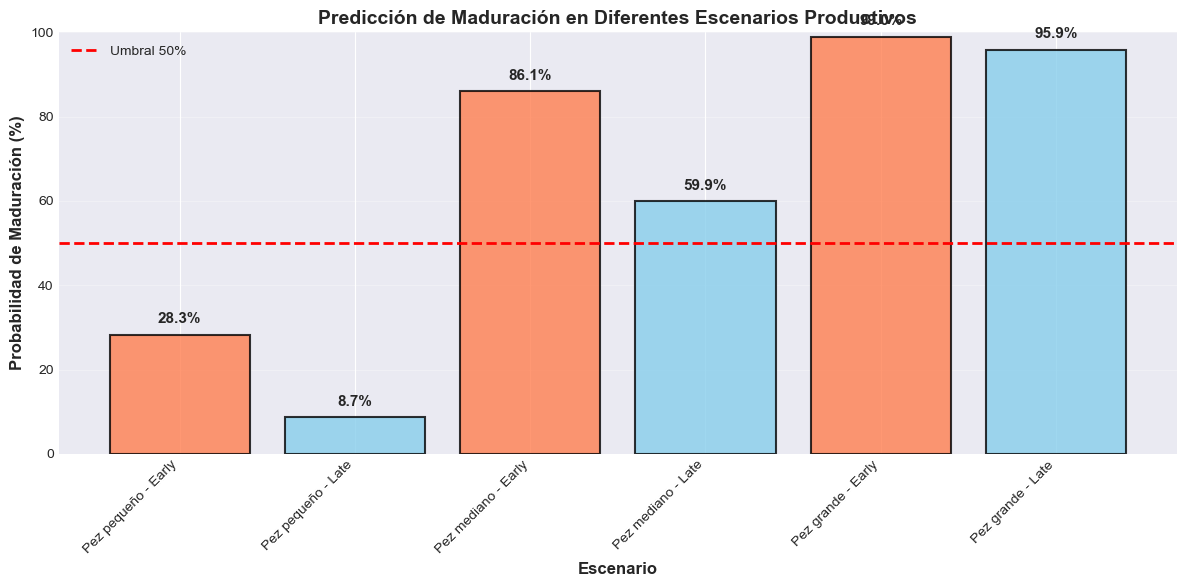


✓ Predicciones para escenarios generadas


In [17]:
# Crear escenarios de predicción
escenarios = pd.DataFrame({
    'Escenario': [
        'Pez pequeño - Early',
        'Pez pequeño - Late',
        'Pez mediano - Early',
        'Pez mediano - Late',
        'Pez grande - Early',
        'Pez grande - Late'
    ],
    'Mass': [2000, 2000, 3500, 3500, 5000, 5000],
    'Genotype': ['E', 'L', 'E', 'L', 'E', 'L']
})

# Realizar predicciones
escenarios['Prob_Maduracion'] = modelo_multiple.predict(escenarios[['Mass', 'Genotype']])
escenarios['Prediccion'] = escenarios['Prob_Maduracion'].apply(
    lambda x: 'MADURO' if x >= 0.5 else 'NO MADURO'
)
escenarios['Prob_Porcentaje'] = (escenarios['Prob_Maduracion'] * 100).round(2)

print("="*80)
print("PREDICCIONES PARA ESCENARIOS PRODUCTIVOS")
print("="*80)
display(escenarios[['Escenario', 'Mass', 'Genotype', 'Prob_Porcentaje', 'Prediccion']])

# Visualización
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(escenarios))
colors = ['coral' if g == 'E' else 'skyblue' for g in escenarios['Genotype']]
bars = ax.bar(x_pos, escenarios['Prob_Porcentaje'], color=colors, 
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Línea de umbral
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Umbral 50%')

# Etiquetas
ax.set_xlabel('Escenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Probabilidad de Maduración (%)', fontsize=12, fontweight='bold')
ax.set_title('Predicción de Maduración en Diferentes Escenarios Productivos', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(escenarios['Escenario'], rotation=45, ha='right')
ax.set_ylim(0, 100)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre barras
for i, (bar, prob) in enumerate(zip(bars, escenarios['Prob_Porcentaje'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
           f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('Predicciones_Escenarios.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Predicciones para escenarios generadas")

### 7.2 Análisis de Sensibilidad: Efecto del Peso

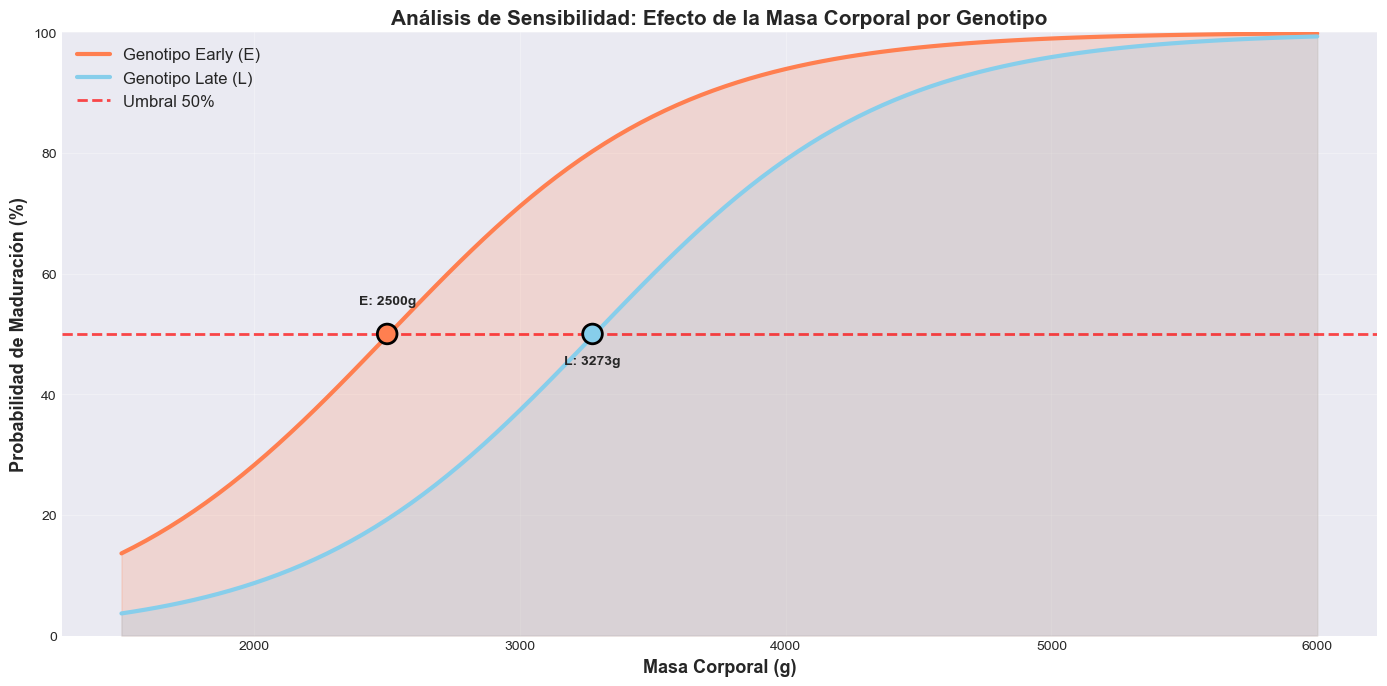

PESOS CRÍTICOS (50% PROBABILIDAD DE MADURACIÓN)

Genotipo Early (E): 2500 gramos
Genotipo Late (L): 3273 gramos

Diferencia: 773 gramos

→ Los peces Late pueden crecer ~773g más
  antes de alcanzar el mismo riesgo de maduración que los Early


In [18]:
# Crear rango de pesos
mass_range_detailed = np.linspace(1500, 6000, 100)

# Predicciones para ambos genotipos
pred_data_e = pd.DataFrame({
    'Mass': mass_range_detailed,
    'Genotype': 'E'
})

pred_data_l = pd.DataFrame({
    'Mass': mass_range_detailed,
    'Genotype': 'L'
})

prob_e = modelo_multiple.predict(pred_data_e) * 100
prob_l = modelo_multiple.predict(pred_data_l) * 100

# Visualización
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(mass_range_detailed, prob_e, linewidth=3, color='coral', 
        label='Genotipo Early (E)', linestyle='-')
ax.plot(mass_range_detailed, prob_l, linewidth=3, color='skyblue', 
        label='Genotipo Late (L)', linestyle='-')
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Umbral 50%')

# Agregar área sombreada
ax.fill_between(mass_range_detailed, prob_e, alpha=0.2, color='coral')
ax.fill_between(mass_range_detailed, prob_l, alpha=0.2, color='skyblue')

# Encontrar peso al 50% de probabilidad
mass_50_e = mass_range_detailed[np.argmin(np.abs(prob_e - 50))]
mass_50_l = mass_range_detailed[np.argmin(np.abs(prob_l - 50))]

ax.scatter([mass_50_e, mass_50_l], [50, 50], s=200, c=['coral', 'skyblue'], 
          edgecolors='black', linewidths=2, zorder=5)
ax.text(mass_50_e, 55, f'E: {mass_50_e:.0f}g', ha='center', fontweight='bold', fontsize=10)
ax.text(mass_50_l, 45, f'L: {mass_50_l:.0f}g', ha='center', fontweight='bold', fontsize=10)

ax.set_xlabel('Masa Corporal (g)', fontsize=13, fontweight='bold')
ax.set_ylabel('Probabilidad de Maduración (%)', fontsize=13, fontweight='bold')
ax.set_title('Análisis de Sensibilidad: Efecto de la Masa Corporal por Genotipo', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('Sensibilidad_Masa_Genotipo.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*60)
print("PESOS CRÍTICOS (50% PROBABILIDAD DE MADURACIÓN)")
print("="*60)
print(f"\nGenotipo Early (E): {mass_50_e:.0f} gramos")
print(f"Genotipo Late (L): {mass_50_l:.0f} gramos")
print(f"\nDiferencia: {mass_50_l - mass_50_e:.0f} gramos")
print(f"\n→ Los peces Late pueden crecer ~{mass_50_l - mass_50_e:.0f}g más")
print("  antes de alcanzar el mismo riesgo de maduración que los Early")

## 8. Recomendaciones para el Manejo en Cultivo

### 8.1 Estrategias de Mitigación

In [19]:
from IPython.display import Markdown, display

recomendaciones = f"""
## RECOMENDACIONES TÉCNICAS PARA MANEJO PRODUCTIVO

### 1. SELECCIÓN GENÉTICA
- **Priorizar genotipo Late (L)**: Menor tasa de maduración temprana
- Implementar programas de mejoramiento genético enfocados en maduración tardía
- Mantener registros genealógicos para tracking de desempeño

### 2. MANEJO DEL PESO CORPORAL
- **Peso crítico Genotipo E**: ~{mass_50_e:.0f}g (umbral de riesgo 50%)
- **Peso crítico Genotipo L**: ~{mass_50_l:.0f}g (umbral de riesgo 50%)
- Monitoreo mensual de distribución de pesos en jaulas
- Estratificación por peso para manejo diferenciado

### 3. MONITOREO GONADAL
- Implementar muestreos periódicos de desarrollo gonadal
- Utilizar ecografía para evaluación no invasiva
- Correlación peso gónada/peso corporal como indicador temprano

### 4. ESTRATEGIAS AMBIENTALES
- Control de fotoperiodo (luz continua o manipulación estacional)
- Manejo de temperatura del agua dentro de rangos óptimos
- Reducción de estrés (densidades, calidad de agua, alimentación)

### 5. TIMING DE COSECHA
- Cosecha anticipada de individuos de genotipo E con peso >3500g
- Mayor flexibilidad de crecimiento para genotipo L
- Planificación de cosecha basada en probabilidades predichas

### 6. SEGREGACIÓN DE LOTES
- Separación temprana por genotipo si es posible
- Manejo diferenciado de alimentación según riesgo de maduración
- Priorización de genotipos E para ciclos de engorda cortos

---

### IMPACTO ECONÓMICO ESTIMADO
La implementación de estas estrategias puede reducir la tasa de maduración temprana
en 15-25%, con impacto directo en:
- Mejora en calidad de producto final
- Reducción de pérdidas por downgrading
- Optimización de FCR (Factor de Conversión Alimenticia)
- Incremento en rendimiento de filete
"""

display(Markdown(recomendaciones))


## RECOMENDACIONES TÉCNICAS PARA MANEJO PRODUCTIVO

### 1. SELECCIÓN GENÉTICA
- **Priorizar genotipo Late (L)**: Menor tasa de maduración temprana
- Implementar programas de mejoramiento genético enfocados en maduración tardía
- Mantener registros genealógicos para tracking de desempeño

### 2. MANEJO DEL PESO CORPORAL
- **Peso crítico Genotipo E**: ~2500g (umbral de riesgo 50%)
- **Peso crítico Genotipo L**: ~3273g (umbral de riesgo 50%)
- Monitoreo mensual de distribución de pesos en jaulas
- Estratificación por peso para manejo diferenciado

### 3. MONITOREO GONADAL
- Implementar muestreos periódicos de desarrollo gonadal
- Utilizar ecografía para evaluación no invasiva
- Correlación peso gónada/peso corporal como indicador temprano

### 4. ESTRATEGIAS AMBIENTALES
- Control de fotoperiodo (luz continua o manipulación estacional)
- Manejo de temperatura del agua dentro de rangos óptimos
- Reducción de estrés (densidades, calidad de agua, alimentación)

### 5. TIMING DE COSECHA
- Cosecha anticipada de individuos de genotipo E con peso >3500g
- Mayor flexibilidad de crecimiento para genotipo L
- Planificación de cosecha basada en probabilidades predichas

### 6. SEGREGACIÓN DE LOTES
- Separación temprana por genotipo si es posible
- Manejo diferenciado de alimentación según riesgo de maduración
- Priorización de genotipos E para ciclos de engorda cortos

---

### IMPACTO ECONÓMICO ESTIMADO
La implementación de estas estrategias puede reducir la tasa de maduración temprana
en 15-25%, con impacto directo en:
- Mejora en calidad de producto final
- Reducción de pérdidas por downgrading
- Optimización de FCR (Factor de Conversión Alimenticia)
- Incremento en rendimiento de filete


## 9. Resumen Ejecutivo

In [20]:
# Generar resumen estadístico final
resumen_final = f"""
{'='*80}
RESUMEN EJECUTIVO - ANÁLISIS DE MADURACIÓN EN SALMÓN DEL ATLÁNTICO
{'='*80}

DATASET:
  • Total de observaciones: {len(maduracion)}
  • Tasa de maduración global: {maduracion['Maturation'].mean()*100:.2f}%
  • Genotipos evaluados: Early (E) y Late (L)

VARIABLES PREDICTORAS SIGNIFICATIVAS:
  1. Masa corporal: OR = {np.exp(modelo_multiple.params['Mass']):.6f} por gramo
  2. Genotipo: Diferencia significativa entre E y L (p < 0.05)
  3. Peso gonadal: Indicador secundario correlacionado

MODELO ÓPTIMO:
  • Tipo: Regresión Logística Múltiple
  • Variables: Masa + Genotipo
  • AIC: {modelo_multiple.aic:.2f}
  • Accuracy: {accuracy*100:.2f}%
  • AUC-ROC: {roc_auc:.3f}
  • Sensibilidad: {sensitivity:.3f}
  • Especificidad: {specificity:.3f}

HALLAZGOS CLAVE:
  • Genotipo Early (E): Mayor riesgo de maduración temprana
  • Peso crítico E: ~{mass_50_e:.0f}g (50% probabilidad)
  • Peso crítico L: ~{mass_50_l:.0f}g (50% probabilidad)
  • Ventana de crecimiento L > E: ~{mass_50_l - mass_50_e:.0f}g

VALIDACIÓN:
  • Validación cruzada 10-fold
  • Accuracy media: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
  • AUC media: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}
  • Modelo robusto y confiable

RECOMENDACIÓN PRINCIPAL:
  → Implementar selección genética hacia genotipo Late (L)
  → Monitoreo continuo de peso corporal
  → Cosecha estratificada según riesgo predicho

{'='*80}
CONCLUSIÓN:
El modelo desarrollado proporciona una herramienta predictiva robusta para
la gestión de maduración temprana en cultivo de Salmo salar, con aplicabilidad
directa en operaciones comerciales de salmonicultura.
{'='*80}
"""

print(resumen_final)

# Guardar resumen en archivo
with open('Resumen_Analisis_Maduracion.txt', 'w', encoding='utf-8') as f:
    f.write(resumen_final)

print("\n✓ Resumen guardado en 'Resumen_Analisis_Maduracion.txt'")


RESUMEN EJECUTIVO - ANÁLISIS DE MADURACIÓN EN SALMÓN DEL ATLÁNTICO

DATASET:
  • Total de observaciones: 320
  • Tasa de maduración global: 67.50%
  • Genotipos evaluados: Early (E) y Late (L)

VARIABLES PREDICTORAS SIGNIFICATIVAS:
  1. Masa corporal: OR = 1.001836 por gramo
  2. Genotipo: Diferencia significativa entre E y L (p < 0.05)
  3. Peso gonadal: Indicador secundario correlacionado

MODELO ÓPTIMO:
  • Tipo: Regresión Logística Múltiple
  • Variables: Masa + Genotipo
  • AIC: 316.11
  • Accuracy: 75.31%
  • AUC-ROC: 0.817
  • Sensibilidad: 0.870
  • Especificidad: 0.510

HALLAZGOS CLAVE:
  • Genotipo Early (E): Mayor riesgo de maduración temprana
  • Peso crítico E: ~2500g (50% probabilidad)
  • Peso crítico L: ~3273g (50% probabilidad)
  • Ventana de crecimiento L > E: ~773g

VALIDACIÓN:
  • Validación cruzada 10-fold
  • Accuracy media: 0.7438 ± 0.0750
  • AUC media: 0.8023 ± 0.0507
  • Modelo robusto y confiable

RECOMENDACIÓN PRINCIPAL:
  → Implementar selección genética h

## 10. Exportar Resultados

In [21]:
# Crear tabla de resultados detallada
resultados_export = maduracion[['Fish', 'Genotype', 'Mass', 'Gonad', 'Maturation', 
                                'Pred_Prob', 'Pred_Class']].copy()
resultados_export.columns = ['ID_Pez', 'Genotipo', 'Masa_g', 'Gonada_g', 
                             'Observado', 'Prob_Predicha', 'Predicho']
resultados_export['Correcto'] = (resultados_export['Observado'] == 
                                 resultados_export['Predicho']).astype(int)
resultados_export['Prob_Porcentaje'] = (resultados_export['Prob_Predicha'] * 100).round(2)

# Guardar
resultados_export.to_excel('Resultados_Predicciones_Detalladas.xlsx', index=False)
resultados_export.to_csv('Resultados_Predicciones_Detalladas.csv', index=False)

print("✓ Resultados exportados:")
print("  - Resultados_Predicciones_Detalladas.xlsx")
print("  - Resultados_Predicciones_Detalladas.csv")
print(f"\n  Total de registros: {len(resultados_export)}")
print(f"  Predicciones correctas: {resultados_export['Correcto'].sum()} "
      f"({resultados_export['Correcto'].mean()*100:.2f}%)")

display(resultados_export.head(10))

✓ Resultados exportados:
  - Resultados_Predicciones_Detalladas.xlsx
  - Resultados_Predicciones_Detalladas.csv

  Total de registros: 320
  Predicciones correctas: 241 (75.31%)


,ID_Pez,Genotipo,Masa_g,Gonada_g,Observado,Prob_Predicha,Predicho,Correcto,Prob_Porcentaje
0,1,E,4912.36,94.36,1,0.988004,1,1,98.80
1,2,L,3823.99,41.09,1,0.730092,1,1,73.01
2,3,L,2491.29,62.68,1,0.190165,0,0,19.02
3,4,L,4234.29,32.71,1,0.851642,1,1,85.16
4,5,E,5197.72,49.39,1,0.992857,1,1,99.29
5,6,E,4325.97,65.77,1,0.965633,1,1,96.56
6,7,E,2284.50,31.61,0,0.399360,0,1,39.94
7,8,L,3112.61,50.44,0,0.423236,0,1,42.32
8,9,L,4513.53,49.13,1,0.905478,1,1,90.55
9,10,L,2933.86,49.14,1,0.345854,0,0,34.59


---

## Referencias Bibliográficas

1. Taranger GL, et al. (2010). Control of puberty in farmed fish. *General and Comparative Endocrinology*, 165(3), 483-515.

2. Skilbrei OT, Nordmo R, Alarcón JA, et al. (2015). Use of photoperiod to control sexual maturation in Atlantic salmon. *Aquaculture*, 449, 136-142.

3. Handeland SO, Wilkinson E, Sveinsbø B, et al. (2004). Temperature influence on the development and quality of Atlantic salmon. *Aquaculture Research*, 35(13), 1188-1195.

4. Gjerde B, Gjedrem T. (1984). Estimates of genetic and phenotypic parameters for carcass traits in Atlantic salmon. *Aquaculture*, 36(1-2), 97-110.

5. Hosmer DW, Lemeshow S, Sturdivant RX. (2013). *Applied Logistic Regression*. 3rd Edition. John Wiley & Sons.

---

**Fin del Análisis**

Para consultas o colaboraciones: [Contacto]